In [147]:
import json
import pandas as pd
import numpy as np
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import matplotlib.pyplot as plt

# 1st Battery of Experiments

In [133]:
# Carregar o arquivo de resultados da primeira bateria de experimentos
with open(r'C:\Users\Gustavo\Documents\Mestrado\curvature-based-isomap\results\dataset_results_1st_battery.json', 'r') as file:
    results = json.load(file)

rows = []

for dataset_name, methods in results.items():
    for method, values in methods.items():
        rows.append([dataset_name, method, values[0][0], values[1][0],values[2][0],values[3][0],values[4][0],values[5][0]])

df = pd.DataFrame(rows, columns=['dataset', 'method', 'RI', 'CH','FM', 'V', 'S','DB'])

In [134]:
metrics = ["RI", "CH", "FM", "V", "S", "DB"]

data = []

# Iterar sobre os datasets e métodos
for dataset, methods in results.items():
    for method, values in methods.items():
        row = [dataset, method] + [value[0][1] for value in values]
        data.append(row)

# Criar o DataFrame com colunas dinâmicas
columns = ["Dataset", "Method"] + metrics
df = pd.DataFrame(data, columns=columns)

# Retirando resultados normalizados, pegando apenas os valores brutos
mask = ~df['Dataset'].str.contains('_norm')

df_filtered = df[mask]

df = df_filtered

# Definindo os métodos e as colunas
methods = ['KISOMAP', 'ISOMAP', 'UMAP', 'Kernel PCA','t-SNE','Laplacian Eigenmaps','RAW']
statistics = []

# Iterando sobre todas as combinações de métricas e métodos
for metric in metrics:
    if '_norm' not in df['Dataset'].unique():
        kiso_data = df[df['Method'] == 'KISOMAP'][metric]
        raw_data = df[df['Method'] == 'RAW'][metric]
    for method in methods:
        if method != 'KISOMAP' and method != "RAW":  # Comparar com KISOMAP
            other_data = df[df['Method'] == method][metric]
            if len(kiso_data) == len(other_data):  # Certificar-se de que temos o mesmo número de amostras
                # Realizando os testes
                stat, p_value = friedmanchisquare(raw_data, kiso_data, other_data)
                p_values_nemenyi = sp.posthoc_nemenyi_friedman(np.array([raw_data, kiso_data, other_data]).T)
                
                # Armazenando os resultados
                statistics.append({
                    'Metric': metric,
                    'Method': method,
                    'Stat': stat,
                    'P-Value Friedman': p_value,
                    # Esse aqui é o valor do teste do KISOMAP vs. (method)
                    'P-Value Nemenyi': p_values_nemenyi[0][2]
                })

            else:
                print(f'Número de amostras não corresponde entre KISOMAP e {method} para a métrica {metric}')

results_df = pd.DataFrame(statistics)

results_df['Test Friedman'] = results_df['P-Value Friedman'].apply(lambda x: 1 if x < 0.05 else 0)
results_df['Stat'] = results_df['Stat'].apply(lambda x: f"{x:.3f}")
results_df['Test Nemenyi'] = results_df['P-Value Nemenyi'].apply(lambda x: 1 if x < 0.05 else 0)
results_df['P-Value Friedman'] = results_df['P-Value Friedman'].apply(lambda x: f"{x:.3f}")
results_df['P-Value Nemenyi'] = results_df['P-Value Nemenyi'].apply(lambda x: f"{x:.3f}")

results_df

,Metric,Method,Stat,P-Value Friedman,P-Value Nemenyi,Test Friedman,Test Nemenyi
0,RI,ISOMAP,9.692,0.008,0.898,1,0
1,RI,UMAP,13.156,0.001,0.953,1,0
2,RI,Kernel PCA,11.565,0.003,0.741,1,0
3,RI,t-SNE,12.087,0.002,0.557,1,0
4,RI,Laplacian Eigenmaps,11.217,0.004,0.898,1,0
5,CH,ISOMAP,38.348,0.000,0.006,1,1
6,CH,UMAP,28.783,0.000,0.000,1,1
7,CH,Kernel PCA,38.348,0.000,0.006,1,1
8,CH,t-SNE,35.826,0.000,0.000,1,1
9,CH,Laplacian Eigenmaps,29.826,0.000,0.033,1,1


In [135]:
###### Exportar tabela em latex
latex_code = results_df.to_latex(index=False)

print(latex_code)

\begin{tabular}{lllllrr}
\toprule
Metric &              Method &   Stat & P-Value Friedman & P-Value Nemenyi &  Test Friedman &  Test Nemenyi \\
\midrule
    RI &              ISOMAP &  9.692 &            0.008 &           0.898 &              1 &             0 \\
    RI &                UMAP & 13.156 &            0.001 &           0.953 &              1 &             0 \\
    RI &          Kernel PCA & 11.565 &            0.003 &           0.741 &              1 &             0 \\
    RI &               t-SNE & 12.087 &            0.002 &           0.557 &              1 &             0 \\
    RI & Laplacian Eigenmaps & 11.217 &            0.004 &           0.898 &              1 &             0 \\
    CH &              ISOMAP & 38.348 &            0.000 &           0.006 &              1 &             1 \\
    CH &                UMAP & 28.783 &            0.000 &           0.000 &              1 &             1 \\
    CH &          Kernel PCA & 38.348 &            0.000 &           

C:\Users\Gustavo\AppData\Local\Temp\ipykernel_9848\1035987248.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_code = results_df.to_latex(index=False)


In [136]:
# Fazendo o melt para transformar os dados em formato longo
df_melted = pd.melt(df_filtered, id_vars=['Dataset', 'Method'], 
                    value_vars=['RI',
                                'CH',
                                'FM',
                                'V', 
                                'S',
                                'DB'],
                    var_name='metric', value_name='value')

# Pivotando para criar uma tabela com subcolunas para cada métrica e método
df_pivot = df_melted.pivot_table(index='Dataset', 
                                 columns=['metric', 'Method'], 
                                 values='value')

# Trocando os níveis do multi-índice nas colunas
df_pivot = df_pivot.swaplevel(i=0, j=1, axis=1)

# Reordenando os níveis após o swap
df_pivot = df_pivot.sort_index(axis=1)


# Alterar para adicionar RI, CH, ... para os resultados ficarem agrupados por métrica
df_gmm = df_pivot[['ISOMAP','KISOMAP','LLE', 'Kernel PCA','Laplacian Eigenmaps','t-SNE','UMAP']].filter(like='CH')
df_gmm.reset_index(inplace=True)  

# Dataset com resultados da métrica escolhida
df_gmm.round(3)

Method,Dataset,ISOMAP,KISOMAP,LLE,Kernel PCA,Laplacian Eigenmaps,t-SNE,UMAP
metric,,CH,CH,CH,CH,CH,CH,CH
0,Engine1,256.294,286.424,138.772,246.233,266.179,474.943,861.686
1,PhishingWebsites,720.176,1199.345,483.474,917.058,946.276,1015.838,1488.274
2,breast-tissue,84.183,185.825,76.000,69.024,143.331,96.334,95.675
3,car-evaluation,597.611,767.018,521.303,465.830,1170.013,664.285,421.268
4,cmc,2516.635,2999.708,8032.563,1429.996,5130.874,1424.729,2647.605
5,conference_attendance,196.601,181.428,156.784,100.367,148.705,271.313,302.382
6,diggle_table_a2,843.602,1240.076,213.333,540.194,252.323,1141.391,232.614
7,hayes-roth,74.503,118.476,76.879,79.029,83.785,118.463,181.038
8,heart-h,386.024,509.045,315.263,384.823,953.684,511.367,1496.305


In [137]:
###### Exportar tabela em latex
latex_code = df_gmm.round(3).to_latex(index=False)

print(latex_code)

\begin{tabular}{lrrrrrrr}
\toprule
                  Dataset &   ISOMAP &  KISOMAP &      LLE & Kernel PCA & Laplacian Eigenmaps &    t-SNE &      UMAP \\
                          &       CH &       CH &       CH &         CH &                  CH &       CH &        CH \\
\midrule
                  Engine1 &  256.294 &  286.424 &  138.772 &    246.233 &             266.179 &  474.943 &   861.686 \\
         PhishingWebsites &  720.176 & 1199.345 &  483.474 &    917.058 &             946.276 & 1015.838 &  1488.274 \\
            breast-tissue &   84.183 &  185.825 &   76.000 &     69.024 &             143.331 &   96.334 &    95.675 \\
           car-evaluation &  597.611 &  767.018 &  521.303 &    465.830 &            1170.013 &  664.285 &   421.268 \\
                      cmc & 2516.635 & 2999.708 & 8032.563 &   1429.996 &            5130.874 & 1424.729 &  2647.605 \\
    conference\_attendance &  196.601 &  181.428 &  156.784 &    100.367 &             148.705 &  271.313 &   302.38

C:\Users\Gustavo\AppData\Local\Temp\ipykernel_9848\1372045903.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_code = df_gmm.round(3).to_latex(index=False)


# 2nd Battery of Experiments

In [138]:
# Carregar o arquivo de resultados da primeira bateria de experimentos
with open(r'C:\Users\Gustavo\Documents\Mestrado\curvature-based-isomap\results\dataset_results_2nd_batteryy.json', 'r') as file:
    results = json.load(file)

rows = []

for dataset_name, methods in results.items():
    for method, values in methods.items():
        rows.append([dataset_name, method, values[0][0], values[1][0],values[2][0],values[3][0],values[4][0],values[5][0]])

df = pd.DataFrame(rows, columns=['dataset', 'method', 'RI', 'CH','FM', 'V', 'S','DB'])

In [143]:
metrics = ["RI", "CH", "FM", "V", "S", "DB"]

data = []

# Iterar sobre os datasets e métodos
for dataset, methods in results.items():
    for method, values in methods.items():
        row = [dataset, method] + [value[0][1] for value in values]
        data.append(row)

# Criar o DataFrame com colunas dinâmicas
columns = ["Dataset", "Method"] + metrics
df = pd.DataFrame(data, columns=columns)

# Retirando resultados normalizados, pegando apenas os valores brutos
mask = ~df['Dataset'].str.contains('_norm')

df_filtered = df[mask]

df = df_filtered

# Definindo os métodos e as colunas
methods = ['KISOMAP', 'ISOMAP', 'UMAP', 'Kernel PCA','t-SNE','Laplacian Eigenmaps','RAW']
statistics = []

# Iterando sobre todas as combinações de métricas e métodos
for metric in metrics:
    if '_norm' not in df['Dataset'].unique():
        kiso_data = df[df['Method'] == 'KISOMAP'][metric]
        raw_data = df[df['Method'] == 'RAW'][metric]
    for method in methods:
        if method != 'KISOMAP' and method != "RAW":  # Comparar com KISOMAP
            other_data = df[df['Method'] == method][metric]
            if len(kiso_data) == len(other_data):  # Certificar-se de que temos o mesmo número de amostras
                # Realizando os testes
                stat, p_value = friedmanchisquare(raw_data, kiso_data, other_data)
                p_values_nemenyi = sp.posthoc_nemenyi_friedman(np.array([raw_data, kiso_data, other_data]).T)
                
                # Armazenando os resultados
                statistics.append({
                    'Metric': metric,
                    'Method': method,
                    'Stat': stat,
                    'P-Value Friedman': p_value,
                    # Esse aqui é o valor do teste do KISOMAP vs. (method)
                    'P-Value Nemenyi': p_values_nemenyi[0][2]
                })

            else:
                print(f'Número de amostras não corresponde entre KISOMAP e {method} para a métrica {metric}')

results_df = pd.DataFrame(statistics)

results_df['Test Friedman'] = results_df['P-Value Friedman'].apply(lambda x: 1 if x < 0.05 else 0)
results_df['Stat'] = results_df['Stat'].apply(lambda x: f"{x:.3f}")
results_df['Test Nemenyi'] = results_df['P-Value Nemenyi'].apply(lambda x: 1 if x < 0.05 else 0)
results_df['P-Value Friedman'] = results_df['P-Value Friedman'].apply(lambda x: f"{x:.3f}")
results_df['P-Value Nemenyi'] = results_df['P-Value Nemenyi'].apply(lambda x: f"{x:.3f}")

results_df

,Metric,Method,Stat,P-Value Friedman,P-Value Nemenyi,Test Friedman,Test Nemenyi
0,RI,ISOMAP,10.706,0.005,0.984,1,0
1,RI,UMAP,13.059,0.001,0.001,1,1
2,RI,Kernel PCA,13.059,0.001,0.271,1,0
3,RI,t-SNE,5.765,0.056,0.453,0,0
4,RI,Laplacian Eigenmaps,12.118,0.002,0.453,1,0
5,CH,ISOMAP,32.118,0.000,0.006,1,1
6,CH,UMAP,30.471,0.000,0.000,1,1
7,CH,Kernel PCA,23.412,0.000,0.010,1,1
8,CH,t-SNE,16.941,0.000,0.099,1,0
9,CH,Laplacian Eigenmaps,14.235,0.001,0.143,1,0


In [140]:
###### Exportar tabela em latex
latex_code = results_df.to_latex(index=False)

print(latex_code)

\begin{tabular}{lllllrr}
\toprule
Metric &              Method &   Stat & P-Value Friedman & P-Value Nemenyi &  Test Friedman &  Test Nemenyi \\
\midrule
    RI &              ISOMAP & 10.706 &            0.005 &           0.984 &              1 &             0 \\
    RI &                UMAP & 13.059 &            0.001 &           0.001 &              1 &             1 \\
    RI &          Kernel PCA & 13.059 &            0.001 &           0.271 &              1 &             0 \\
    RI &               t-SNE &  5.765 &            0.056 &           0.453 &              0 &             0 \\
    RI & Laplacian Eigenmaps & 12.118 &            0.002 &           0.453 &              1 &             0 \\
    CH &              ISOMAP & 32.118 &            0.000 &           0.006 &              1 &             1 \\
    CH &                UMAP & 30.471 &            0.000 &           0.000 &              1 &             1 \\
    CH &          Kernel PCA & 23.412 &            0.000 &           

C:\Users\Gustavo\AppData\Local\Temp\ipykernel_9848\1035987248.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_code = results_df.to_latex(index=False)


In [141]:
# Fazendo o melt para transformar os dados em formato longo
df_melted = pd.melt(df_filtered, id_vars=['Dataset', 'Method'], 
                    value_vars=['RI',
                                'CH',
                                'FM',
                                'V', 
                                'S',
                                'DB'],
                    var_name='metric', value_name='value')

# Pivotando para criar uma tabela com subcolunas para cada métrica e método
df_pivot = df_melted.pivot_table(index='Dataset', 
                                 columns=['metric', 'Method'], 
                                 values='value')

# Trocando os níveis do multi-índice nas colunas
df_pivot = df_pivot.swaplevel(i=0, j=1, axis=1)

# Reordenando os níveis após o swap
df_pivot = df_pivot.sort_index(axis=1)


# Alterar para adicionar RI, CH, ... para os resultados ficarem agrupados por métrica
df_gmm = df_pivot[['ISOMAP','KISOMAP','LLE', 'Kernel PCA','Laplacian Eigenmaps','t-SNE','UMAP']].filter(like='CH')
df_gmm.reset_index(inplace=True)  

# Dataset com resultados da métrica escolhida
df_gmm.round(3)

Method,Dataset,ISOMAP,KISOMAP,LLE,Kernel PCA,Laplacian Eigenmaps,t-SNE,UMAP
metric,,CH,CH,CH,CH,CH,CH,CH
0,AP_Breast_Kidney,293.023,407.940,31.414,46.681,30.651,94.244,1333.769
1,AP_Endometrium_Breast,37.360,72.955,15.224,38.841,16.315,2.582,398.728
2,AP_Omentum_Kidney,111.372,152.415,28.494,39.688,32.205,6.422,243.543
3,AP_Ovary_Lung,71.161,106.420,18.852,27.400,21.318,23.741,481.771
4,F-MNIST,1294.098,1667.028,632.789,803.510,-1.000,1560.303,17462.261
5,MNIST,548.536,845.111,335.384,1034.668,-1.000,973.831,7074.975
6,OVA_Uterus,291.010,407.636,168.098,271.983,145.781,445.343,395.179
7,Pen-Digits,615.638,754.331,219.870,589.806,1600.383,990.556,3648.226
8,cnae-9,269.573,1402.280,253.161,1087.244,3867.813,1538.056,2269.341


In [145]:
###### Exportar tabela em latex
latex_code = df_gmm.round(3).to_latex(index=False)

print(latex_code)

\begin{tabular}{lrrrrrrr}
\toprule
              Dataset &   ISOMAP &  KISOMAP &      LLE &  Kernel PCA & Laplacian Eigenmaps &    t-SNE &      UMAP \\
                      &       CH &       CH &       CH &          CH &                  CH &       CH &        CH \\
\midrule
     AP\_Breast\_Kidney &  293.023 &  407.940 &   31.414 &      46.681 &              30.651 &   94.244 &  1333.769 \\
AP\_Endometrium\_Breast &   37.360 &   72.955 &   15.224 &      38.841 &              16.315 &    2.582 &   398.728 \\
    AP\_Omentum\_Kidney &  111.372 &  152.415 &   28.494 &      39.688 &              32.205 &    6.422 &   243.543 \\
        AP\_Ovary\_Lung &   71.161 &  106.420 &   18.852 &      27.400 &              21.318 &   23.741 &   481.771 \\
              F-MNIST & 1294.098 & 1667.028 &  632.789 &     803.510 &              -1.000 & 1560.303 & 17462.261 \\
                MNIST &  548.536 &  845.111 &  335.384 &    1034.668 &              -1.000 &  973.831 &  7074.975 \\
           O

C:\Users\Gustavo\AppData\Local\Temp\ipykernel_9848\1372045903.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_code = df_gmm.round(3).to_latex(index=False)


# Análise gráfica dos resultados

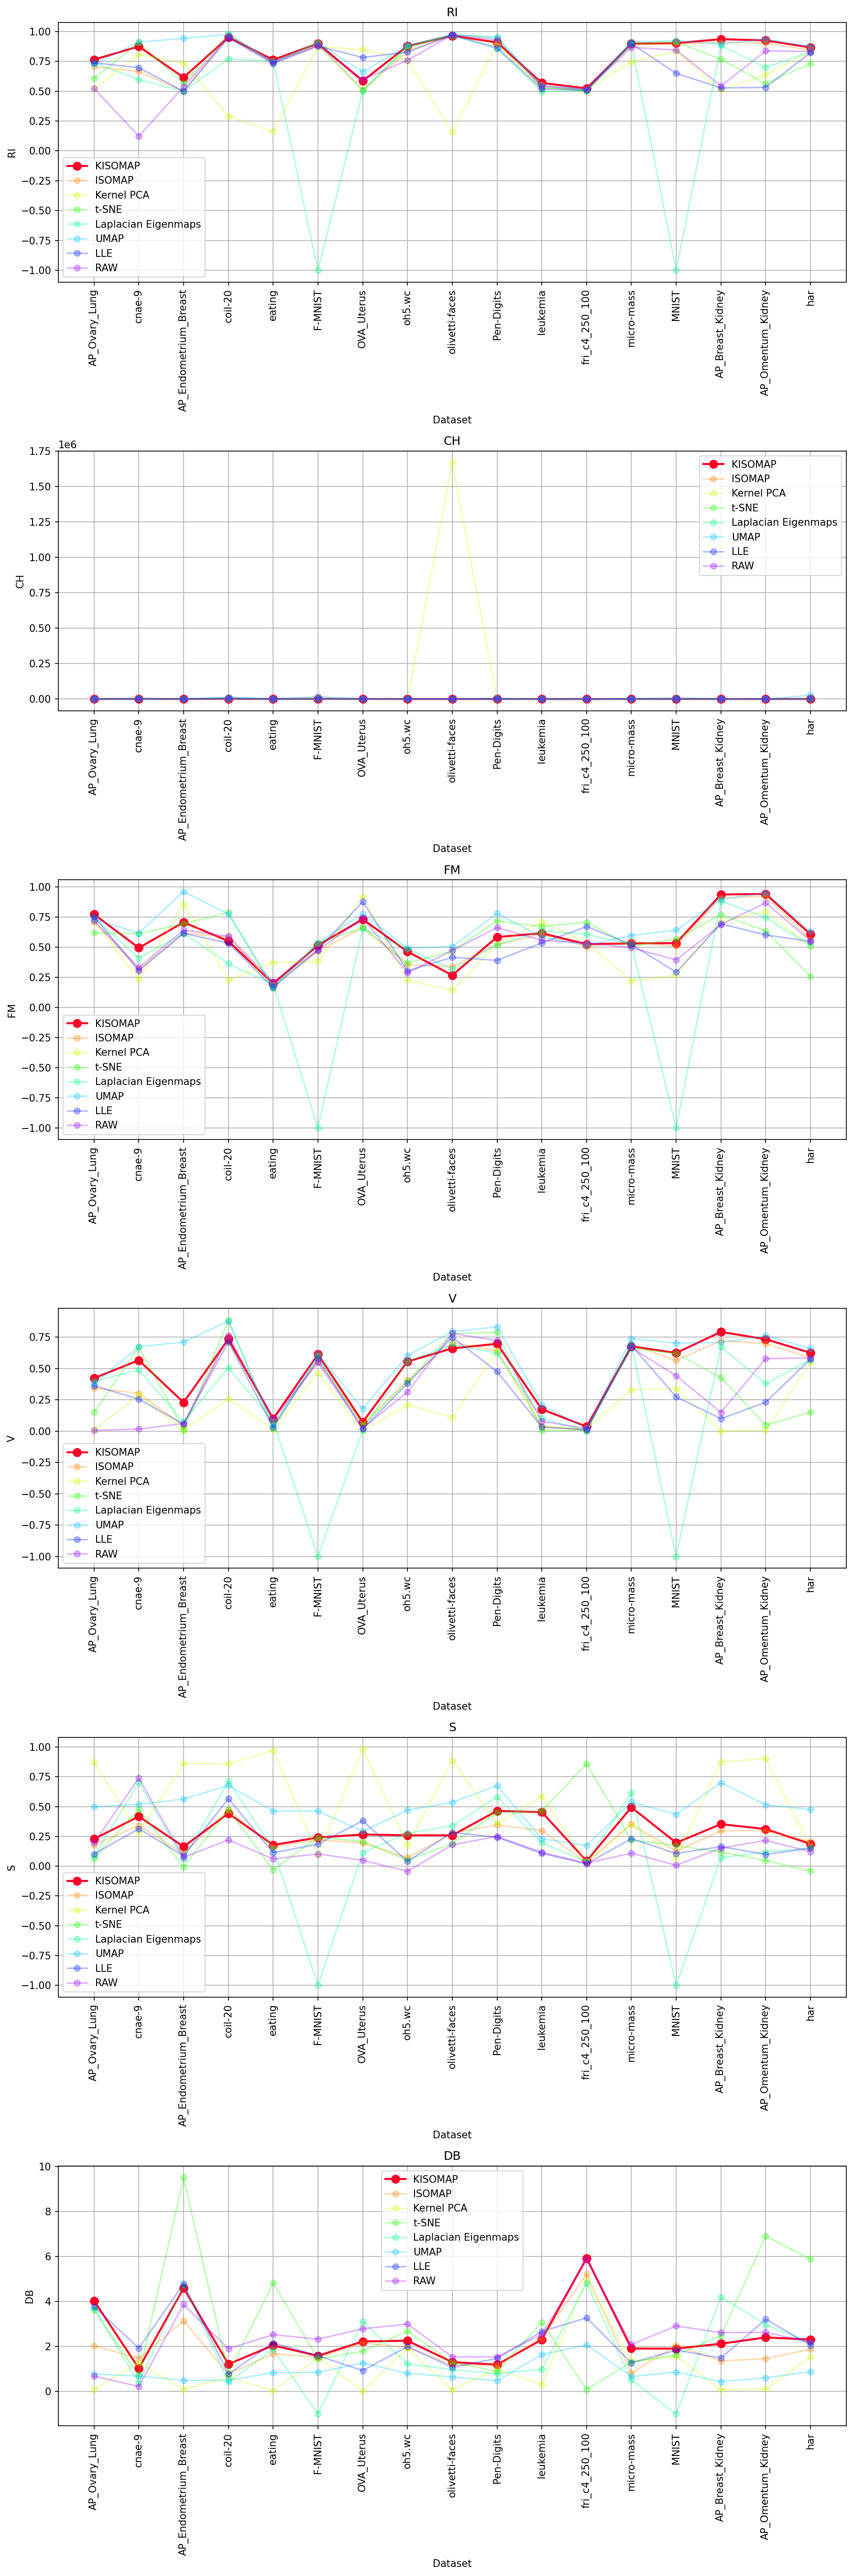

In [150]:
df = df_filtered
# Definir as cores para cada método usando o colormap 'gist_rainbow'
colormap = plt.get_cmap('gist_rainbow')
methods = df['Method'].unique()
colors = {method: colormap(i / len(methods)) for i, method in enumerate(methods)}

# Lista das novas colunas que serão plotadas
metrics = ['RI', 'CH', 'FM', 'V', 'S', 'DB']

# Criar a figura com subplots, ajustando o tamanho e DPI
fig, axs = plt.subplots(len(metrics), 1, figsize=(12, 6 * len(metrics)), dpi=150)

for ax, metric in zip(axs, metrics):
    for method in df['Method'].unique():
        subset = df[df['Method'] == method]
        if method == 'KISOMAP':
            ax.plot(subset['Dataset'], subset[metric], 
                    marker='o', label=method, color=colors[method], linewidth=2, markersize=8)
        else:
            ax.plot(subset['Dataset'], subset[metric], 
                    marker='o', label=method, color=colors.get(method, 'gray'), alpha=0.3)
    
    ax.set_xlabel('Dataset')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric}')
    ax.grid(True)
    ax.legend()  # Adiciona a legenda
    ax.tick_params(axis='x', rotation=90)  # Rotaciona os rótulos do eixo x se necessário

plt.tight_layout()
plt.show()